## Setup

Imports, device, and helper functions for viewing images.

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

Loading a pretrained pipeline:

In [2]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\kerem\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\kerem\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Generating sample images

  0%|          | 0/1000 [00:00<?, ?it/s]

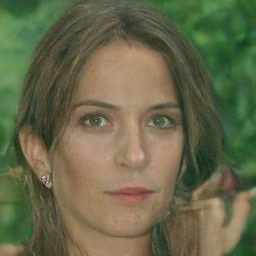

In [5]:
images = image_pipe().images
images[0]

It took 1m 21.4s to execute (generate) the image above. Slow.

Instead of 1000 number of steps, we could use num_inference_steps=40. This scheduler configuration results with faster timings. 

In [4]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

c:\Users\kerem\anaconda3\envs\diffusion\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


In [5]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

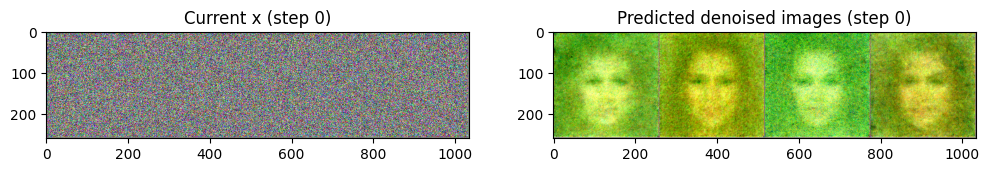

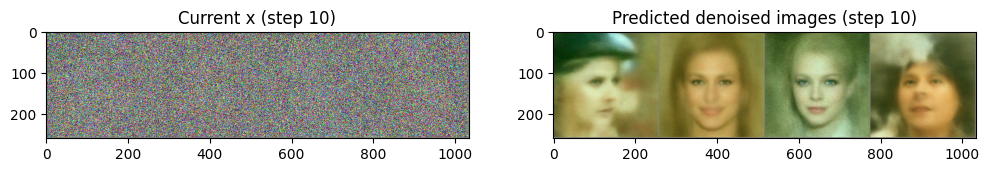

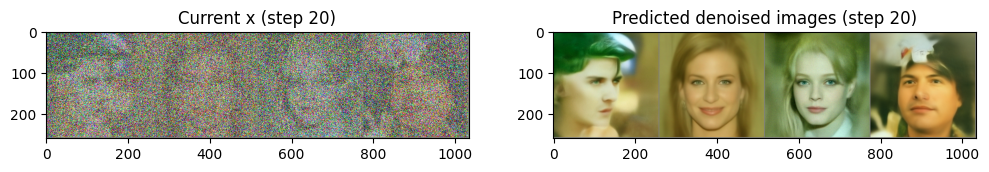

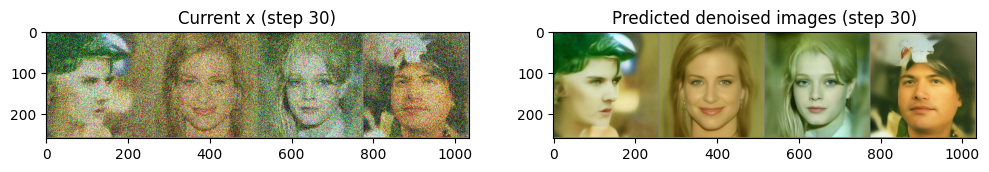

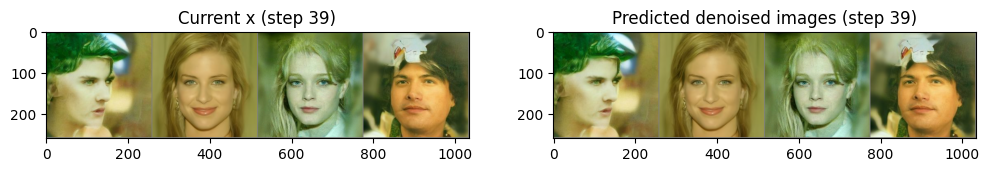

In [6]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

As the step increases, image outputs become are more and more refined.

  0%|          | 0/100 [00:00<?, ?it/s]

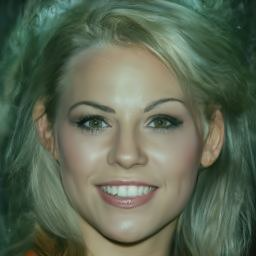

In [10]:
image_pipe.scheduler = scheduler
# we can change the number of steps
images = image_pipe(num_inference_steps=100).images
images[0]

## Fine Tuning

Using a pretrained pipeline, we will re train the model

Very similar to Unit1, just with a little difference. We are using an existing pipeline.

I will use butterflies dataset, just like in the course because I am curious of the results. I will use a batch size of 2 this time, I hope my GPU memory doesn't overload.

Repo card metadata block was not found. Setting CardData to empty.


Previewing batch:


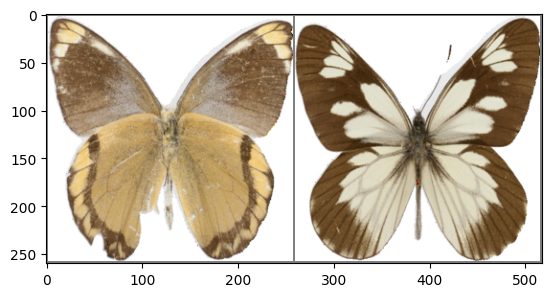

In [5]:
# @markdown load and prepare a dataset:
# Not on Colab? Comments with #@ enable UI tweaks like headings or user inputs
# but can safely be ignored if you're working on a different platform.

dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 2  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

I am using value of 4 for grad_accumulation_steps. Remembering that I am using a batch size of 2, with this config my effective batch size is 8 (4x2), so it is more robust to noise (accumulation!).

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 average loss: 0.013651999455629267


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 average loss: 0.012175572190441016


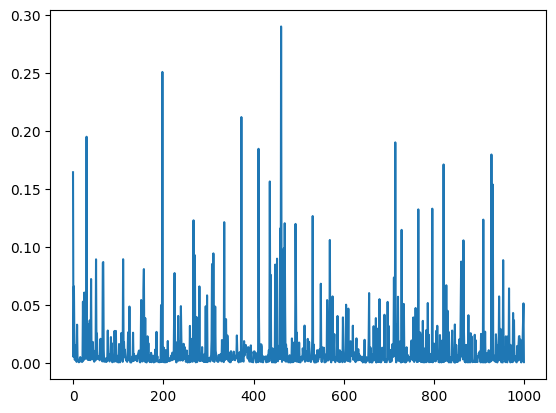

In [8]:
num_epochs = 2  # @param
lr = 1e-5  # @param
grad_accumulation_steps = 4  # @param

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()  # clear gradients at start of each epoch
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward()

        # Gradient accumulation: update every grad_accumulation_steps (effective batch = batch_size * grad_accumulation_steps)
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Flush any remaining accumulated gradients (e.g. if len(dataloader) not divisible by grad_accumulation_steps)
    if (step + 1) % grad_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

# Plot the loss curve:
plt.plot(losses)

Well it took more than 17 minutes to fine tune the model. We should add logging to code to convenience. An example of that is finetune_model.py

We should terminate the fine tuning proccess when the model performs well enough.

Generating some images with the fine tuned model.

We can use our scheduler settings from the original pipeline ddpm-bedroom-256, since the config is the same.

c:\Users\kerem\anaconda3\envs\diffusion\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

0it [00:00, ?it/s]

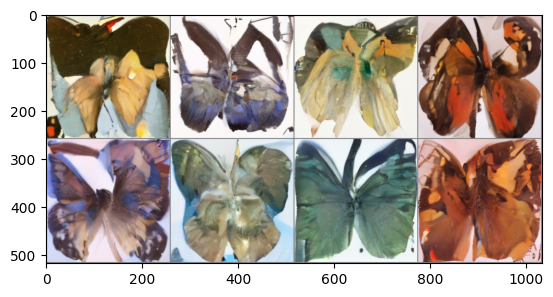

In [ ]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_pretrained("google/ddpm-bedroom-256")
scheduler.set_timesteps(num_inference_steps=40)
image_pipe.scheduler = scheduler

x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

Let's save our fine tuned pipeline

In [12]:
image_pipe.save_pretrained("finetuned-model-faces-butterfly")

..and push it to the huggingface hub

In [2]:
# @title Upload a locally saved pipeline to the hub

# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "ddpm-finetuned-model-faces-butterfly-2-epochs"  # @param What you want it called on the hub
local_folder_name = "finetuned-model-faces-butterfly"  # @param Created by the script or one you created via image_pipe.save_pretrained('save_name')
description = "Model fine tuned for Diffusion Course. "  # @param
hub_model_id = get_full_repo_name(model_name) 
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/keremaslan/ddpm-finetuned-model-faces-butterfly-2-epochs/commit/288b849b70e9ebdf2ab09f46383ceea4d45d6d7e', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='288b849b70e9ebdf2ab09f46383ceea4d45d6d7e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keremaslan/ddpm-finetuned-model-faces-butterfly-2-epochs', endpoint='https://huggingface.co', repo_type='model', repo_id='keremaslan/ddpm-finetuned-model-faces-butterfly-2-epochs'), pr_revision=None, pr_num=None)

After this, we will work with this pretrained pipeline.

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kerem\anaconda3\envs\diffusion\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


0it [00:00, ?it/s]

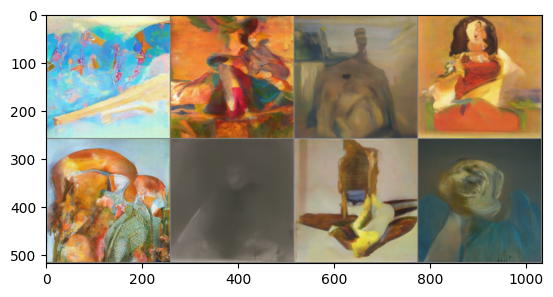

In [2]:
 # Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# 8 random noise images
x = torch.randn(8, 3, 256, 256).to(device)

 # sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

 # View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

Guidance, first defining our color loss function.

In [3]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()  # Mean absolute difference between the image pixels and the target color
    return error

At each diffusion step we get a predicted clean image (x0) from the model’s noise prediction, compute a loss that measures how far that x0 is from a target color, then take the gradient of that loss with respect to the current noisy sample and nudge the sample in the direction that reduces the color loss before applying the usual scheduler step. That way the generated images stay coherent but are steered toward the chosen color (in this example, light teal because our color_loss function's default is (0.1, 0.9, 0.5), which is light teal).

0it [00:00, ?it/s]

0 loss: 27.645957946777344
10 loss: 10.114340782165527
20 loss: 9.493770599365234
30 loss: 9.667732238769531


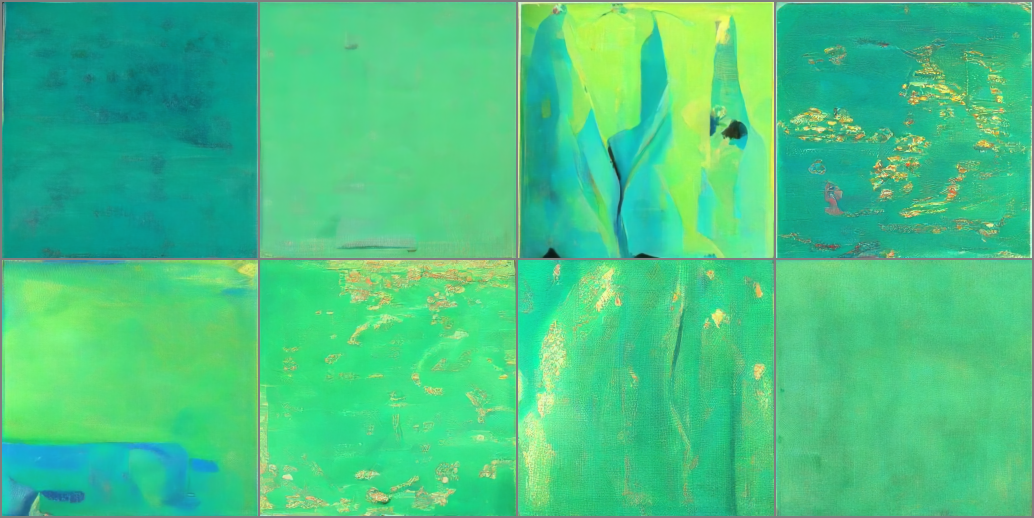

In [4]:
# Variant 1: shortcut method

# The guidance scale determines the strength of the effect
guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

Now, another alternative method that uses much more GPU memory (nearly double). It should be more accurate.1

0it [00:00, ?it/s]

0 loss: 28.34224510192871
10 loss: 15.081514358520508
20 loss: 14.264383316040039
30 loss: 14.531517028808594


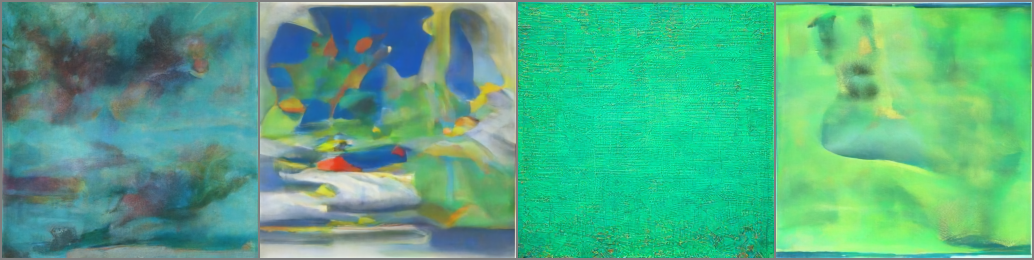

In [5]:
# Variant 2: setting x.requires_grad before calculating the model predictions

guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

As we can see from the above, it is more accurate per say.

Variant 1 = guidance gradient only through the scheduler (no UNet backprop).

Variant 2 = guidance gradient through UNet + scheduler (more accurate, but more memory and compute).


Making another example with variant 1, this time with 30 loss scale and with the color burgundy (0.5, 0.0, 0.13).

0it [00:00, ?it/s]

0 loss: 18.546602249145508
10 loss: 8.230765342712402
20 loss: 8.014158248901367
30 loss: 8.202873229980469


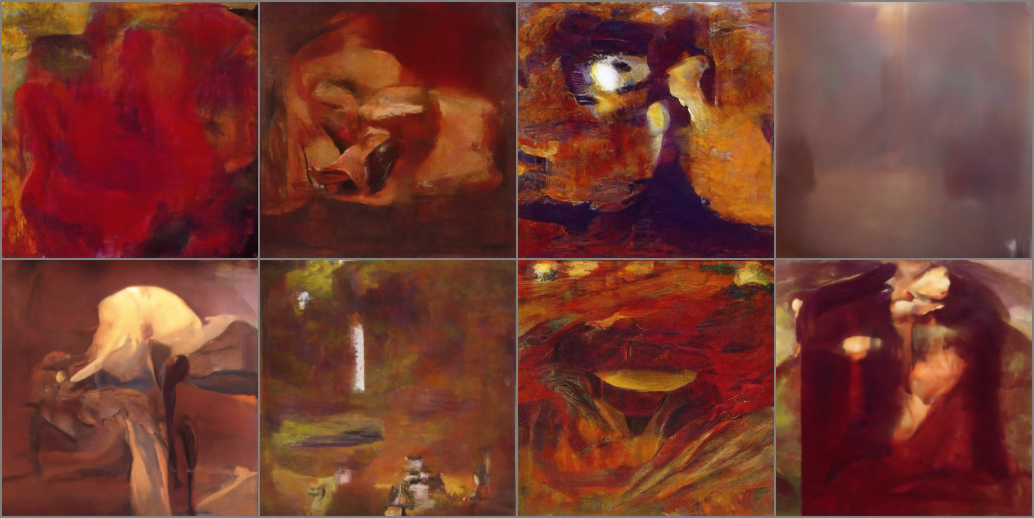

In [8]:
# Variant 1: shortcut with burgundy
guidance_loss_scale = 30
x = torch.randn(8, 3, 256, 256).to(device)
BURGUNDY_RGB = (0.5, 0.0, 0.13)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    x = x.detach().requires_grad_()
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample
    loss = color_loss(x0, BURGUNDY_RGB) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    cond_grad = -torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
display(Image.fromarray(np.array(im * 255).astype(np.uint8)))

And with variant 2 with the same settings

0it [00:00, ?it/s]

0 loss: 18.44346046447754
10 loss: 6.3167948722839355
20 loss: 5.742727279663086
30 loss: 5.932060241699219


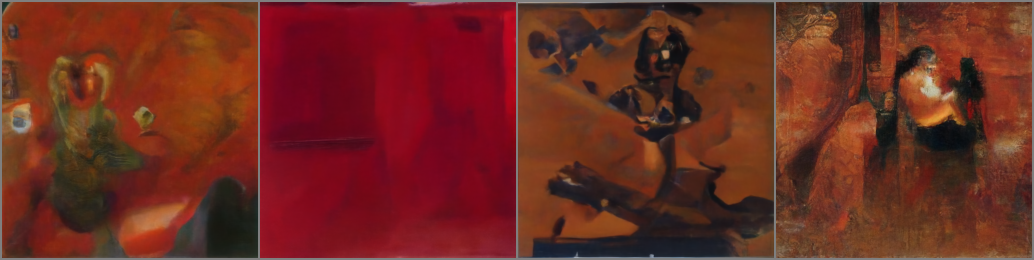

In [9]:
# Variant 2: full gradient with burgundy
guidance_loss_scale = 30
x = torch.randn(4, 3, 256, 256).to(device)
BURGUNDY_RGB = (0.5, 0.0, 0.13)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)
    noise_pred = image_pipe.unet(model_input, t)["sample"]
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0, BURGUNDY_RGB) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    cond_grad = -torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
display(Image.fromarray(np.array(im * 255).astype(np.uint8)))

CLIP Guidance. This gives us the ability to guide the images using text captions.

Loading a CLIP model (ViT-B-32)


In [11]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(
            5
        ),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

c:\Users\kerem\anaconda3\envs\diffusion\lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


C:\Users\kerem\AppData\Local\Temp\ipykernel_38428\813417652.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


0it [00:00, ?it/s]

Step: 0 , Guidance loss: 7.330799579620361
Step: 25 , Guidance loss: 7.344438552856445


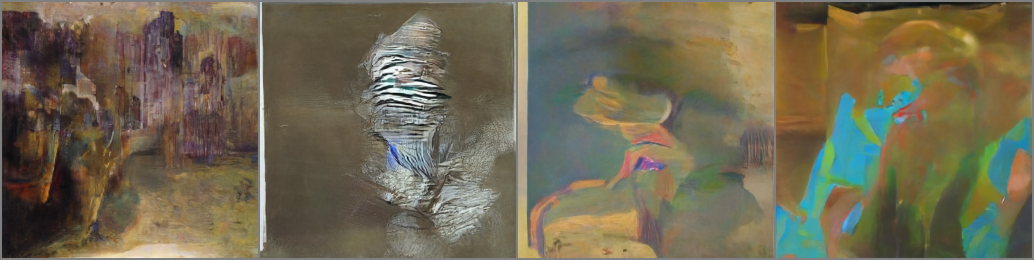

In [11]:
prompt = "Blue orchid, blue flower painting"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(
    device
)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

Not looking so good :/. Could be better with better prompts and better parameters, and with a bigger ViT model